In [19]:
import scipy as sc
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt

In [20]:
# BACKGROUND - define useful functions

# gives X(z) as defined in (8) Wang and Mota (note - k vanishes when calculating X)

def X(z, cosmo):
    
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_tilde = cosmo
    Omega_m = Omega_c + Omega_b
    Omega_lambda = 1 - Omega_m - Omega_r - Omega_k + alpha_tilde
    
    return 1 + 4 * alpha_tilde * (Omega_m * (1 + z) ** 3 + Omega_r * (1 + z)** 4 + Omega_k * (1 + z) ** 2 + Omega_lambda)

# gives E(z) = H(z) / H0

def E(z , cosmo):
    
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_tilde = cosmo
    Omega_m = Omega_c + Omega_b
    Omega_lambda = 1 - Omega_m - Omega_r - Omega_k + alpha_tilde
    

    if alpha_tilde == 0:
        ans = np.sqrt(Omega_m * (1 + z) ** 3 + Omega_r * (1 + z) ** 4 + Omega_k * (1 + z) ** 2 + Omega_lambda)
    else:
        
        ans = np.sqrt((np.sqrt(X(z , cosmo)) - 1)/(2 * alpha_tilde))
    
    return ans

# gives dE/dz

def dEdz(z , cosmo):
    
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_tilde = cosmo
    Omega_m = Omega_c + Omega_b
    
    # Wang and Mota
    dEdz = ((3 * Omega_m * (1 + z) ** 2) + (4 * Omega_r * (1 + z) ** 3) + (2 * Omega_k * (1 + z)))/(2 * E(z , cosmo) * np.sqrt(X(z , cosmo)))
    
    return dEdz

# gives dE/dx, x = lna

def dEdx(z , cosmo):
    
    dEdx = -(1 + z) * dEdz(z , cosmo)
    
    return dEdx

In [21]:
# PERTURBATIONS - define useful functions

# ---- finding f ------
#returns derivative of f with respect to x
def dfdx(f , x , cosmo):
    
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_tilde = cosmo
    Omega_m = Omega_c + Omega_b
    
    z = np.exp(-x) - 1
    dfdx = -f ** 2 -(2 + dEdx(z , cosmo)/E(z , cosmo)) * f -(3/2) * Omega_m * \
    (1 + 2 * alpha_tilde * E(z , cosmo) * (2*dEdx(z , cosmo) - E(z , cosmo)))/((2 * alpha_tilde * E(z , cosmo) ** 2 + 1)\
                                                                               * E(z , cosmo) ** 2)
    
    return dfdx

# ---- finding sigma8 ------
# returns second derivative of sigma8 (equivalent to delta_m up to boundary conditions) with respect to x
def ddsigma8ddx (sigma8 , dsigma8dx , x , cosmo):
    
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_tilde = cosmo
    Omega_m = Omega_c + Omega_b
    z = np.exp(-x) - 1

    Eval = E(z , cosmo)
    dEvaldx = dEdx(z , cosmo)
    
    ddsigma8ddx = -(2 + dEvaldx/Eval)*dsigma8dx - (3/2)*Omega_m*sigma8*(1 + 2 * alpha_tilde * Eval * (2*dEvaldx - Eval))/\
    ((2 * alpha_tilde * Eval ** 2 + 1)* Eval ** 2)
    return ddsigma8ddx


def coupled_sigma8_dsigma8dx(y , x , cosmo):
    sigma8 , dsigma8dx = y
    ydot = [dsigma8dx, ddsigma8ddx(sigma8 , dsigma8dx , x , cosmo)]
    return ydot

In [22]:
# Define constants

cosmo = [0.27 , 0.045 , 0 , 9.2e-5 , 0]                      #  Omega_c , Omega_b , Omega_k , Omega_r , alpha_tilde 

# create coord times
p = 3
x = np.linspace( 0, -0.7, int(10**p))

# create boundary condition for f: value of f at x = -2
BC = (0.27  + 0.045) ** 0.55

#find solution
f = odeint(dfdx, BC, x, args=(cosmo,), mxstep=int(1e4))
f = np.transpose(f)[0]

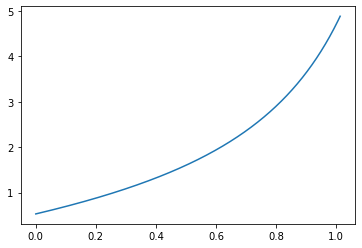

In [23]:
plt.plot(np.exp(-x) - 1,f)


In [24]:
# create boundary condition for sigma8
BCs = [0.78,0.78]


#find solution
soln = odeint(coupled_sigma8_dsigma8dx, BCs, x, args=(cosmo,), mxstep=int(1e4))

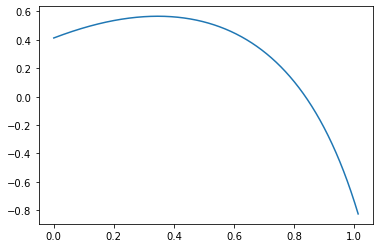

In [25]:
sigma8 = soln[:,0]

plt.plot(np.exp(-x) - 1,sigma8*f)



Text(0, 0.5, 'z')

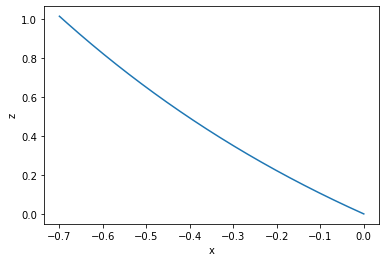